# Simple PINN for an elastic plate with an elliptical hole 

## Geometry

We want to model a quarter of a plate with an elliptical hole. The domain itself is represented by collocation points, the boundaries are represented by uniformly sampled points along the perimeter.

In [56]:
import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
import numpy as np
from scipy.stats import qmc
from plotly.express.colors import sequential
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


torch.set_default_dtype(torch.float64)
from global_constants import L, R, MU, LBD, N1, N2

from new_plate_elliptic_hole import Plate 

# Elliptical axis in x direction
Rx = 0.14
Ry = R**2 / Rx
# Edge samples
N = 40
# Number of collocation points
M = 500

# Epochs
pretraining_epochs = 7000
epochs = 5000
# Batch size
batch_size = 64
# Learning rate
lr = lr = 0.005
# Scheduler step width
scheduler_step = 500
# Gamma factor of scheduler
scheduler_gamma = 0.6
# Number of hidden neurons
hn = 20



def generate_radii_list(min_Ra_x, max_Ra_x, step):
    if step == 0:
        rad_x_list = [min_Ra_x, max_Ra_x]
    else:
        num_steps = int((max_Ra_x - min_Ra_x) / step) + 1
        rad_x_list = np.linspace(min_Ra_x, max_Ra_x, num_steps)
        rad_x_list = [round(rad_x, 2) for rad_x in rad_x_list]
    rad_y_list = []
    for rad_x in rad_x_list:
        rad_y_list.append(R**2 / rad_x)
    return rad_x_list, rad_y_list

def generate_multiple_plates(min_Ra_x, max_Ra_x, step_size):

    list_collo = torch.empty(0,3,requires_grad=True)
    list_top = torch.empty(0,3,requires_grad=True)
    list_right = torch.empty(0,3,requires_grad=True)
    list_left = torch.empty(0,3,requires_grad=True)
    list_bottom = torch.empty(0,3,requires_grad=True)
    list_hole = torch.empty(0,5,requires_grad=True)

    rad_x_list, rad_y_list = generate_radii_list(min_Ra_x, max_Ra_x, step_size)
    for rad_x in rad_x_list:
        p1 = Plate(rad_x, N, M)
        #data_one_plate -> [collocation, top, right, left, bottom, hole, n_hole]
        collo_points, top_points, right_points, left_points, bottom_points, hole_points = p1.generate_dataset()
        list_collo = torch.cat((list_collo, collo_points), dim=0)
        list_top = torch.cat((list_top, top_points), dim=0)
        list_right = torch.cat((list_right, right_points), dim=0)
        list_left = torch.cat((list_left, left_points), dim=0)
        list_bottom = torch.cat((list_bottom, bottom_points), dim=0)
        list_hole = torch.cat((list_hole, hole_points), dim=0)
        
    return list_collo, list_top, list_right, list_left, list_bottom, list_hole 

def generate_multiple_plates_dict(min_Ra_x, max_Ra_x):
    dict_plate_points = dict()
    tuples = [
            ("x_collo", 0, 0),
            ("y_collo", 0, 1),
            ("x_top", 1, 0),
            ("y_top", 1, 1),
            ("x_right", 2, 0),
            ("y_right", 2, 1),
            ("x_left", 3, 0),
            ("y_left", 3, 1),
            ("x_bottom", 4, 0),
            ("y_bottom", 4, 1),
            ("x_hole", 5, 0),
            ("y_hole", 5, 1),   
        ] 
    
    rad_x_list, rad_y_list = generate_radii_list(min_Ra_x, max_Ra_x, 0.01)
    for rad_x in rad_x_list:
        p1 = Plate(rad_x, N, M)
        #data_one_plate -> [collocation, top, right, left, bottom, hole, n_hole]
        data_one_plate = p1.generate_dataset()

        for tuple in tuples:
            key = tuple[0]
            dict_plate_points.setdefault(key, []).append(data_one_plate[tuple[1]][:,tuple[2]])
        #plotting one plate
        #p1.plot_plate_with_hole(*data_one_plate)
    for key in dict_plate_points: 
        #appending list of tensors to one tensor
        dict_plate_points[key] = torch.cat(dict_plate_points[key])
        print(key, "besteht aus",dict_plate_points[key].size(), "Datenpunkten")

    collo_points = torch.column_stack([dict_plate_points["x_collo"], dict_plate_points["y_collo"]])
    top_points = torch.column_stack([dict_plate_points["x_top"], dict_plate_points["y_top"]])
    right_points = torch.column_stack([dict_plate_points["x_right"], dict_plate_points["y_right"]])
    left_points = torch.column_stack([dict_plate_points["x_left"], dict_plate_points["y_left"]])
    bottom_points = torch.column_stack([dict_plate_points["x_bottom"], dict_plate_points["y_bottom"]])
    hole_points = torch.column_stack([dict_plate_points["x_hole"], dict_plate_points["y_hole"]])

    return collo_points, top_points, right_points, left_points, bottom_points, hole_points



p99 = Plate(0.14, N, M)
collocation, top, right, left, bottom, hole = p99.generate_dataset()
p99.plot_plate_with_hole(collocation, top, right, left, bottom, hole)


## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $u: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ with five hidden layers having 20 neurons each.

In [57]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(3, hn)
        self.hidden_layer2 = torch.nn.Linear(hn, hn)
        self.hidden_layer3 = torch.nn.Linear(hn, hn)
        self.hidden_layer4 = torch.nn.Linear(hn, hn)
        self.hidden_layer5 = torch.nn.Linear(hn, hn)
        self.output_layer = torch.nn.Linear(hn, 2)

    def forward(self, inputs):
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output


def reset_net_parameters(net):
    for layer in net.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

#reset all network parameters    
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()



## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} - b_1 = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} - b_2 = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [58]:
def epsilon(xyr):
    # Compute deformation gradient
    #inputs = torch.column_stack([x,y])
    dudx = torch.func.jacrev(net)(xyr)
    # print(np.shape(xx))
    # print(xx)
    return 0.5 * (dudx[:,:-1] + dudx[:,:-1].T)

# def epsilon(x):
#     # Compute deformation gradient
#     disp = net(x)
#     print(np.shape(disp))
#     print(disp)
#     u = disp[:,0]
#     v = disp[:,1]
#     u_x = torch.autograd.grad(u.sum(), x[:, 0], create_graph=True)[0]
#     v_x = torch.autograd.grad(v.sum(), x[:, 0], create_graph=True)[0]
#     u_y = torch.autograd.grad(u.sum(), x[:, 1], create_graph=True)[0]
#     v_y = torch.autograd.grad(v.sum(), x[:, 1], create_graph=True)[0]

#     gradx = torch.column_stack([u_x, v_x])
#     grady = torch.column_stack([u_y, v_y])
#     gradient = torch.stack([gradx, grady], dim=2)

#    return 0.5 * (gradient + torch.transpose(gradient, 1, 2))

def sigma(xyr):
    # Compute (small deformation) strain
    eps = epsilon(xyr)
    # Compute linear elastic strain (assuming plane stress)
    return 2.0 * MU * eps + (2*LBD*MU)/(2*MU+LBD) * torch.trace(eps) * torch.eye(2)


def pde_residual(xyr):
    # Compute stress gradient
    dsdx = torch.func.jacrev(sigma)(xyr)
    # Momentum balance in x direction
    residual_x = dsdx[0, 0, 0] + dsdx[0, 1, 1] 
    # Momentum balance in y direction
    residual_y = dsdx[1, 0, 0] + dsdx[1, 1, 1]
    return residual_x, residual_y

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Top: 

$$ \sigma \cdot n = N_2 n$$

Right: 

$$ \sigma \cdot n = N_1 n$$

In [59]:
mse = torch.nn.MSELoss()


def compute_physics_losses(complete_collo, top, right, left, bottom, hole):
    # pde
    res_x, res_y = torch.vmap(pde_residual)(complete_collo)
    zeros = torch.zeros_like(res_x)
    pde_error = mse((res_x), zeros) + mse((res_y), zeros)

    # left boundary
    pred_left = net(left)
    bc_left = torch.zeros_like(pred_left[:, 0])
    left_error = mse(pred_left[:, 0], bc_left)

    # bottom boundary
    pred_bottom = net(bottom)
    bc_bottom = torch.zeros_like(pred_bottom[:, 1])
    bottom_error = mse(pred_bottom[:, 1], bc_bottom)

    # top boundary
    pred_stress_top = torch.vmap(sigma)(top)
    pred_s_top_yy = pred_stress_top[:,1,1]
    pred_s_top_xy = pred_stress_top[:,0,1]
    s_top_yy = N2*torch.ones_like(pred_s_top_yy)
    s_top_xy = torch.zeros_like(pred_s_top_xy)
    top_error = mse(pred_s_top_yy, s_top_yy) + mse(pred_s_top_xy, s_top_xy)

    # right boundary
    pred_stress_right = torch.vmap(sigma)(right)
    pred_s_right_xx = pred_stress_right[:,0,0]
    pred_s_right_xy = pred_stress_right[:,1,0]
    s_right_xx = N1*torch.ones_like(pred_s_right_xx)
    s_right_xy = torch.zeros_like(pred_s_right_xy)
    right_error = mse(pred_s_right_xx, s_right_xx) + mse(pred_s_right_xy, s_right_xy)


    # hole boundary
    stress_hole = torch.vmap(sigma)(hole[:,:3])
    n_hole = hole[:,-2:]
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:, 0])
    hole_error = mse(traction[:, 0], zeros) + mse(traction[:, 1], zeros)


    return (left_error, right_error, bottom_error, top_error, hole_error, pde_error)

## Training 

In [60]:
net = Net()
# Specify a path
PATH = 'net_param\net_foropti.pth'
#net.load_state_dict(torch.load(PATH))

In [61]:

#scheduler = ExponentialLR(optimizer, gamma=0.999)
loss_history = []
weight_history = []

# Weight of PDE lossWeight_NEU: 1.8841683879627231e-06, Weight_PDE: 3.1355081392423563e-06
# Weight of Neumann loss explicitly for the right and top boundary condition
W_NEU = 6.4531255763296895e-06 #previous value -> 1.88e-06
W_PDE = 8.376708219353885e-06 #previous value -> 3.14e-06
# Weight of Neumann loss explicitly for the hole boundary condition
W_HNEU = 8.2e-05
# Weight of data losses
W_STRESS = 0.0 #previous value -> 1.0e-07 
W_DISP = 0.0



#Weight_NEU and Weight_PDE as PyTorch nn parameter 
Weight_NEU = torch.tensor(W_NEU, requires_grad=True) #previous value -> 6.4531255763296895e-06
Weight_PDE = torch.tensor(W_PDE, requires_grad=True) #previous value -> 8.376708219353885e-06
Weight_HNEU = torch.tensor(W_HNEU, requires_grad=True)
Weight_STRESS = torch.tensor(W_STRESS, requires_grad=True)

target_loss = torch.tensor(5e-06)






def training(Weight_NEU, Weight_PDE, compare_rad_x, target_loss):

    net.apply(weight_reset)
    
    p1 = Plate(compare_rad_x, N, M) 
    data_input, data_output, data_hole = p1.load_reference_data()
    compare_collo, compare_top, compare_right, compare_left, compare_bottom, compare_hole = p1.generate_dataset()

    #collocation, top, right, left, bottom, hole = generate_multiple_plates(0.04, 0.18, 0.01)
    collocation, top, right, left, bottom, hole = generate_multiple_plates(0.14, 0.14, 0.0)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
    print("Starting with Adam optimizer...")
    for epoch in tqdm(range(pretraining_epochs)):
        # Permutation to shuffle collocation points randomly in each epoch
        permutation = torch.randperm(collocation.size()[0])

        for i in range(0, collocation.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            collo = collocation[indices]
            optimizer.zero_grad()

            # Compute physics losses
            left_l, right_l, bottom_l, top_l, hole_l, pde_l = compute_physics_losses(collo, top, right, left, bottom, hole)

            # Aggregate losses
            dirichlet_losses = left_l + bottom_l 
            neumann_losses = right_l + top_l 
            hole_neumann_losses = hole_l
            loss = (
                dirichlet_losses
                + Weight_NEU * neumann_losses
                + Weight_HNEU * hole_neumann_losses
                + Weight_PDE * pde_l
            )

            # Make optimization step after batch
            loss.backward(retain_graph=True)
            optimizer.step()

        # Make scheduler step after full epoch
        scheduler.step()
        
        # append loss to history (=for plotting)
        with torch.autograd.no_grad():
            loss_history.append(float(loss.data))

    print(f"hole_loss:  {hole_neumann_losses}, neumann_loss:  {neumann_losses}, dirichlet_loss: {dirichlet_losses}, ")

    return loss_history

pretraining_loss_history = training(Weight_NEU, Weight_PDE, 0.14, target_loss)

Starting with Adam optimizer...


  0%|          | 0/7000 [00:00<?, ?it/s]

100%|██████████| 7000/7000 [52:18<00:00,  2.23it/s]

hole_loss:  0.021099259368774135, neumann_loss:  0.03675134750761627, dirichlet_loss: 4.4272733741298327e-07, 


100%|██████████| 5000/5000 [29:03<00:00,  2.87it/s]  


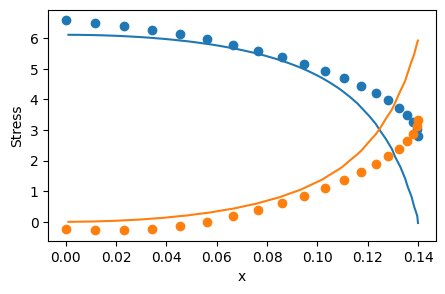

Weight_HNEU: 8.2e-05, Weight_NEU: 6.4531255763296895e-06, Weight_PDE: 8.376708219353885e-06, Weight_STRESS: 0.0, Stress Error: 1.2175863930665785


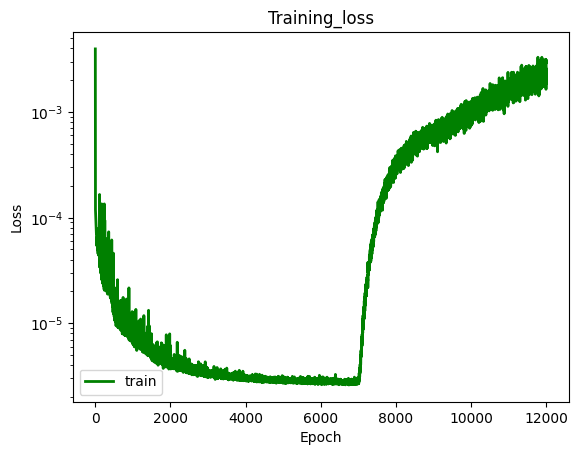

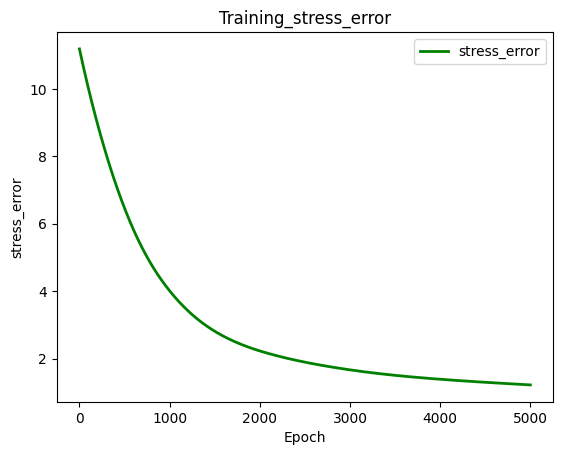

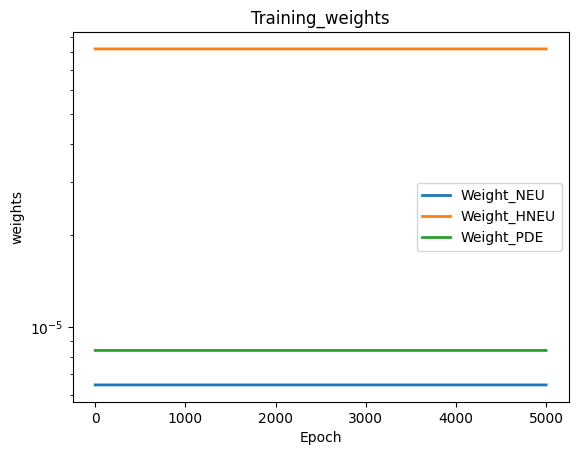

In [62]:

#scheduler = ExponentialLR(optimizer, gamma=0.999)
loss_history = pretraining_loss_history
stress_error_history = []
weight_NEU_history = []
weight_HNEU_history = []
weight_PDE_history = []

lr_loss = 5e-08
lr_weight = 1e-07

# Weight of PDE lossWeight_NEU: 1.8841683879627231e-06, Weight_PDE: 3.1355081392423563e-06
# Weight of Neumann loss explicitly for the right and top boundary condition
W_NEU = 6.4531255763296895e-06 #previous value -> 1.88e-06
W_PDE = 8.376708219353885e-06 #previous value -> 3.14e-06
# Weight of Neumann loss explicitly for the hole boundary condition
W_HNEU = 8.2e-05
# Weight of data losses
W_STRESS = 0.0 #previous value -> 1.0e-07 
W_DISP = 0.0

#Weight_NEU and Weight_PDE as PyTorch nn parameter 
Weight_NEU = torch.tensor(W_NEU, requires_grad=True) #previous value -> 6.4531255763296895e-06
Weight_PDE = torch.tensor(W_PDE, requires_grad=True) #previous value -> 8.376708219353885e-06
Weight_HNEU = torch.tensor(W_HNEU, requires_grad=True)
Weight_STRESS = torch.tensor(W_STRESS, requires_grad=True)

#generate plate for training
p1 = Plate(0.14, N, M) 
data_input, data_output, data_hole = p1.load_reference_data()
compare_collo, compare_top, compare_right, compare_left, compare_bottom, compare_hole = p1.generate_dataset()

#collocation, top, right, left, bottom, hole = generate_multiple_plates(0.04, 0.18, 0.01)
collocation, top, right, left, bottom, hole = generate_multiple_plates(0.14, 0.14, 0.0)
data_hole = data_hole.numpy()
data_hole = data_hole[data_hole[:, 0].argsort()]
data_stress_x = data_hole[:, 2]
data_stress_y = data_hole[:, 3]

#interpolate data_stress_x and data_stress_y
f_stress_x = interp1d(data_hole[:, 0], data_hole[:, 2], kind='cubic')
f_stress_y = interp1d(data_hole[:, 0], data_hole[:, 3], kind='cubic')
x_new = np.linspace(data_hole[:, 0][-1], data_hole[:, 0][0], compare_hole[:, 0].size(dim=0))
y_stress_x = torch.tensor(f_stress_x(x_new))
y_stress_y = torch.tensor(f_stress_y(x_new))



optimizer_loss = torch.optim.Adam(net.parameters(), lr=lr_loss)
optimizer_stress_error = torch.optim.Adam([Weight_NEU, Weight_HNEU, Weight_PDE], lr=lr_weight)
for epoch in tqdm(range(epochs)):
    optimizer_stress_error.zero_grad()

    permutation = torch.randperm(collocation.size()[0])
    for i in range(0, collocation.size()[0], batch_size):
        indices = permutation[i : i + batch_size]
        collo = collocation[indices]
        optimizer_loss.zero_grad()

        # Compute physics losses
        left_l, right_l, bottom_l, top_l, hole_l, pde_l = compute_physics_losses(collo, top, right, left, bottom, hole)

        # Aggregate losses
        dirichlet_losses = left_l + bottom_l 
        neumann_losses = right_l + top_l 
        hole_neumann_losses = hole_l
        loss = (
            dirichlet_losses
            + Weight_NEU * neumann_losses
            + Weight_HNEU * hole_neumann_losses
            + Weight_PDE * pde_l
        )

            # compare computed stressError(PINN) with actual stressError
        stress_hole = torch.vmap(sigma)(compare_hole[:, :-2])
        stressError = (
            mse(stress_hole[:, 0, 0], y_stress_x) 
            + mse(stress_hole[:, 1, 1], y_stress_y)
        )

        # Make optimization step after batch
        stressError.backward(retain_graph=True)
        optimizer_loss.step()
        optimizer_stress_error.step()

    # append loss and stressError to history (=for plotting)
    with torch.autograd.no_grad():
            loss_history.append(float(loss.data))
            stress_error_history.append(float(stressError.data))
            #stress_error_history.extend([ (float(stressError.data)) for i in range(0, collocation.size()[0], batch_size)])
            weight_NEU_history.append(Weight_NEU.item())
            weight_HNEU_history.append(Weight_HNEU.item())
            weight_PDE_history.append(Weight_PDE.item())

with torch.autograd.no_grad():
    plt.figure(figsize=(5, 3))
    plt.plot(compare_hole[:, 0], stress_hole[:, 0, 0], "o", color="tab:blue", label="σ_xx (PINN)")
    plt.plot(data_hole[:, 0], data_hole[:, 2], "-", color="tab:blue", label="σ_xx (FEM)")
    plt.plot(compare_hole[:, 0], stress_hole[:, 1, 1], "o", color="tab:orange", label="σ_yy (PINN)")
    plt.plot(data_hole[:, 0], data_hole[:, 3], "-", color="tab:orange", label="σ_yy (FEM)")
    plt.xlabel("x")
    plt.ylabel("Stress")
    #plt.legend()
    plt.show()

    # print weights and stress error and modify weight values for the next iteration
    print(f"Weight_HNEU: {Weight_HNEU.item()}, Weight_NEU: {Weight_NEU.item()}, Weight_PDE: {Weight_PDE.item()}, Weight_STRESS: {Weight_STRESS.item()}, Stress Error: {stressError.item()}") 
    #Weight_STRESS = Weight_STRESS *1/1.1
    # Weight_NEU = Weight_NEU * (1.1/1.0)
    # Weight_PDE = Weight_PDE * (1.1/1.0)
    # Weight_HNEU = Weight_HNEU * (1.1/1.0)

#plt.figure(figsize=(8, 4))
plt.plot(loss_history, c='g', label='train', linewidth=2.0)
plt.yscale("log")
plt.title("Training_loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(stress_error_history, c='g', label='stress_error', linewidth=2.0)
plt.title("Training_stress_error")
plt.ylabel("stress_error")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(weight_NEU_history, label='Weight_NEU', linewidth=2.0)
plt.plot(weight_HNEU_history, label='Weight_HNEU', linewidth=2.0)
plt.plot(weight_PDE_history, label='Weight_PDE', linewidth=2.0)
plt.yscale("log")
plt.title("Training_weights")
plt.ylabel("weights")
plt.xlabel("Epoch")
plt.legend()
plt.show()







## Visualization of results

In [63]:
val_rad_x = 0.14
val_plate = Plate(val_rad_x, N, M) 
data_input, data_output, data_hole = val_plate.load_reference_data()
val_collo, val_top, val_right, val_left, val_bottom, val_hole = val_plate.generate_dataset()

stress_hole = torch.vmap(sigma)(val_hole[:,:-2])
data_hole = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole = data_hole[data_hole[:, 0].argsort()]

with torch.no_grad():
    fig = go.Figure()
    m1 = dict(color="blue")
    m2 = dict(color="orange")
    fig.add_trace(
        go.Scatter(
            x=hole[:, 0],
            y=stress_hole[:, 0, 0],
            marker=m1,
            mode="markers",
            name="σ_xx (PINN)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=data_hole[:, 0],
            y=data_hole[:, 2],
            marker=m1,
            mode="lines",
            name="σ_xx (FEM)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=hole[:, 0],
            y=stress_hole[:, 1, 1],
            marker=m2,
            mode="markers",
            name="σ_yy (PINN)",
        )
    )
    fig.add_trace(
        go.Scatter(
            x=data_hole[:, 0],
            y=data_hole[:, 3],
            marker=m2,
            mode="lines",
            name="σ_yy (FEM)",
        )
    )
    fig.update_layout(
        template="none", width=600, height=400, title="Stress at hole", showlegend=True
    )
    fig.show()

In [64]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_r = Rx * np.ones(np.shape(val_x))
val_domain = np.vstack([val_x.ravel(), val_y.ravel(), val_r.ravel()]).T
mask = (
    ((val_domain[:, 0] ** 2) / (Rx**2)) + ((val_domain[:, 1] ** 2) / (Ry**2))
) > 1
val = torch.tensor(val_domain[mask], requires_grad=True).double()


# Compute model predictions on the validation domain
disp = net(val)
def_val = val[:, :-1] + disp
stress = torch.vmap(sigma)(val)
mises = torch.sqrt(
    stress[:, 0, 0] ** 2
    + stress[:, 1, 1] ** 2
    - stress[:, 0, 0] * stress[:, 1, 1]
    + 3 * stress[:, 0, 1] ** 2
)
# print([loss.item() for loss in compute_les(val)])


@torch.no_grad()
def make_plot(x, y, variable, title, cmap=sequential.Viridis, size=8.0):
    fig = go.Figure()

    # Plot boundaries
    m = dict(color="black")
    fig.add_trace(go.Scatter(x=top[:, 0], y=top[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=bottom[:, 0], y=bottom[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=left[:, 0], y=left[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=right[:, 0], y=right[:, 1], mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=hole[:, 0], y=hole[:, 1], mode="lines", marker=m))

    # Plot variable values
    m = dict(color=variable, colorscale=cmap, size=size, colorbar=dict(thickness=10))
    fig.add_trace(go.Scatter(x=x, y=y, marker=m, mode="markers"))

    # plot settings
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none", width=400, height=400, title=title, showlegend=False
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


# Compute data error
s_data = data_output[:, 0:3]
s_pred = torch.vmap(sigma)(data_input[:, 0:3])
ds_xx = s_data[:, 0] - s_pred[:, 0, 0]
ds_yy = s_data[:, 1] - s_pred[:, 1, 1]
ds_xy = s_data[:, 2] - s_pred[:, 0, 1]


# Plot stress errors
cmap = sequential.RdBu_r
make_plot(*data_input[:, 0:2].T, ds_xx, "Stress error xx", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T, ds_yy, "Stress error yy", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T, ds_xy, "Stress error xy", size=2.0, cmap=cmap)

# Plot stresses
make_plot(*def_val.T, stress[:, 0, 0], "Stress xx")
make_plot(*def_val.T, stress[:, 0, 1], "Stress xy")
make_plot(*def_val.T, stress[:, 1, 1], "Stress yy")
make_plot(*def_val.T, mises, "Mises stress")

# Plot displacements
make_plot(*def_val.T, disp[:, 0], "Displacement in x", cmap=sequential.Inferno)
make_plot(*def_val.T, disp[:, 1], "Displacement in y", cmap=sequential.Inferno)
